In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [2]:
data = []

pattern = r'Configuration: \{"goal": "(?P<goal>\w+)(?: \((?P<negotiation>.*?)\))?"[^}]*\}. Negotiation time: (?P<time>\d+\.\d+) seconds. Rounds: (?P<rounds>\d+). Result: (?P<result>\S+)'

sim_files = [os.path.join('../results', f) for f in os.listdir('../results') if f.startswith('simulation-')] # and (f.endswith('2.log') or f.endswith('pc.log'))]

for log_file_path in sim_files:
    with open(log_file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                context = "airport" if match.group("goal") == "navigate_to_gate" else "hospital"
                negotiation = match.group("negotiation")
                rounds = int(match.group("rounds")) // 2 + (int(match.group("rounds")) % 2 > 0)
                time = float(match.group("time"))
                result = match.group("result")
                setting = "offrobot" if "offrobot" in log_file_path else "onrobot"
                data.append({"negotiation": negotiation, "rounds": rounds, "negotiation_time": time, "result": result, "context": context, "deployment": setting})

df = pd.DataFrame(data)
df.head()

,negotiation,rounds,negotiation_time,result,context,deployment
0,"User: A, Negotiating against: B",5,0.700,winner,hospital,onrobot
1,"User: A, Negotiating against: C",6,1.010,loser,hospital,onrobot
2,"User: A, Negotiating against: D",7,0.918,loser,hospital,onrobot
3,"User: A, Negotiating against: E",6,0.795,no-agreement,hospital,onrobot
4,"User: A, Negotiating against: F",5,0.786,loser,hospital,onrobot


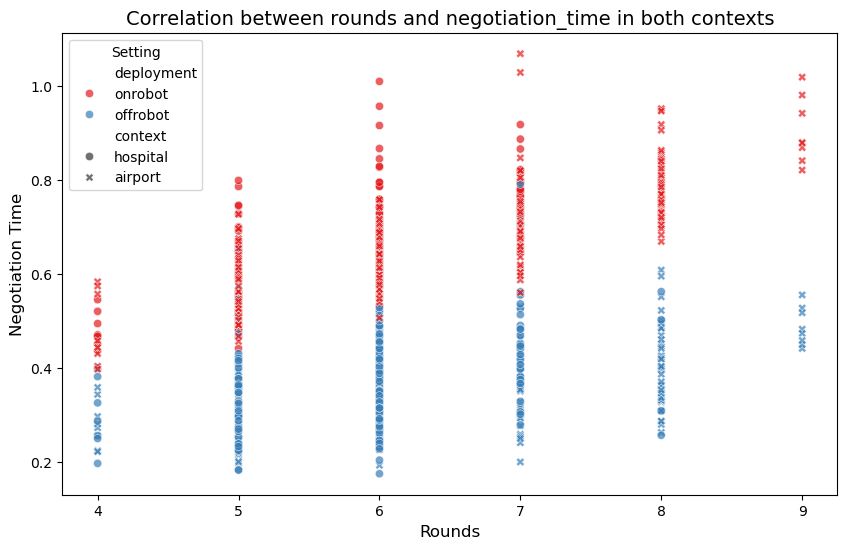

In [3]:
plt.figure(figsize=(10, 6))

plotting_df = df

sns.scatterplot(
    data=plotting_df,
    x='rounds',
    y='negotiation_time',
    hue='deployment',
    style='context',
    palette='Set1',
    alpha=0.7
)

plt.title("Correlation between rounds and negotiation_time in both contexts", fontsize=14)
plt.xlabel("Rounds", fontsize=12)
plt.ylabel("Negotiation Time", fontsize=12)
plt.legend(title="Setting", fontsize=10)

plt.show()

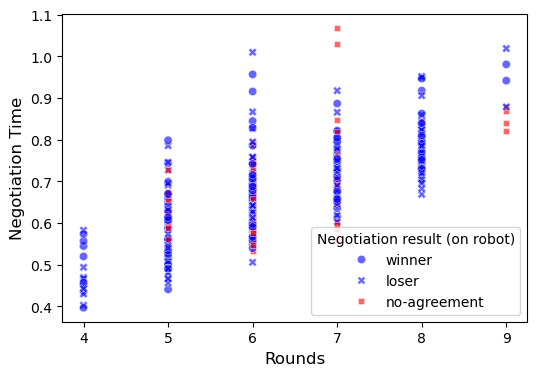

In [4]:
plt.figure(figsize=(6, 4))

onrobot_df = df[df['deployment'] == 'onrobot']

sns.scatterplot(data=onrobot_df, x='rounds', y='negotiation_time', hue='result', style='result', palette={'no-agreement': 'red', 'winner': 'blue', 'loser': 'blue'}, alpha=0.6)

plt.xlabel("Rounds", fontsize=12)
plt.ylabel("Negotiation Time", fontsize=12)
plt.legend(title="Negotiation result (on robot)", fontsize=10)

plt.show()


In [5]:
# Stats
overall_stats = df.groupby('deployment').agg({
    'negotiation_time': ['mean', 'min', 'max', 'std']
})
print("Overall statistics for negotiation time by deployment:")
print(overall_stats)

airport_stats = df[df['context']=='airport'].groupby('deployment').agg({
    'negotiation_time': ['mean', 'min', 'max', 'std']
})
print("\n\n\nAirport context:")
print(airport_stats)

hospital_stats = df[df['context']=='hospital'].groupby('deployment').agg({
    'negotiation_time': ['mean', 'min', 'max', 'std']
})
print("\n\n\nHospital context:")
print(hospital_stats)


Overall statistics for negotiation time by deployment:
           negotiation_time                        
                       mean    min    max       std
deployment                                         
offrobot           0.369958  0.174  0.791  0.099416
onrobot            0.672789  0.397  1.069  0.114616



Airport context:
           negotiation_time                        
                       mean    min    max       std
deployment                                         
offrobot           0.354917  0.192  0.608  0.086242
onrobot            0.681811  0.397  1.069  0.123708



Hospital context:
           negotiation_time                        
                       mean    min    max       std
deployment                                         
offrobot           0.385000  0.174  0.791  0.109223
onrobot            0.663767  0.436  1.010  0.104307


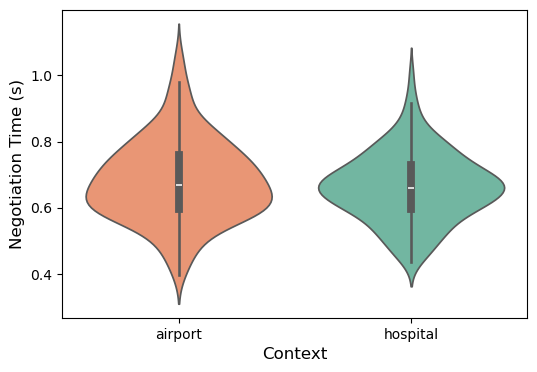

In [6]:
plt.figure(figsize=(6, 4))

onrobot_df = df[df['deployment'] == 'onrobot']

sns.violinplot(
    data=onrobot_df,
    x='context',
    y='negotiation_time',
    hue="context",
    palette='Set2',
    order=onrobot_df['context'].unique()[::-1]
)

plt.xlabel("Context", fontsize=12)
plt.ylabel("Negotiation Time (s)", fontsize=12)

plt.show()

In [7]:
# Negotiation_time < 0.8 per context
long_negotiations_airport = onrobot_df[(onrobot_df['negotiation_time'] < 0.8) & (onrobot_df['context'] == 'airport')]
long_negotiations_hospital = onrobot_df[(onrobot_df['negotiation_time'] < 0.8) & (onrobot_df['context'] == 'hospital')]

num_long_airport = long_negotiations_airport.shape[0]
num_long_hospital = long_negotiations_hospital.shape[0]
num_long_total = num_long_airport + num_long_hospital

total_airport = onrobot_df[onrobot_df['context'] == 'airport'].shape[0]
total_hospital = onrobot_df[onrobot_df['context'] == 'hospital'].shape[0]
total_onrobot_cases = onrobot_df.shape[0]

perc_long_airport = (num_long_airport / total_airport) * 100 if total_airport else 0
perc_long_hospital = (num_long_hospital / total_hospital) * 100 if total_hospital else 0
perc_long_total = (num_long_total / total_onrobot_cases) * 100 if total_onrobot_cases else 0

print(f"Negotiations < 0.8s (airport): {num_long_airport} ({perc_long_airport:.2f}%)")
print(f"Negotiations < 0.8s (hospital): {num_long_hospital} ({perc_long_hospital:.2f}%)")
print(f"Negotiations < 0.8s (total): {num_long_total} ({perc_long_total:.2f}%)")
print("\nCases (airport):")
print(long_negotiations_airport)
print("\nCases (hospital):")
print(long_negotiations_hospital)
# print(long_negotiations)
# print(long_negotiations)

Negotiations < 0.8s (airport): 151 (83.89%)
Negotiations < 0.8s (hospital): 164 (91.11%)
Negotiations < 0.8s (total): 315 (87.50%)

Cases (airport):
                         negotiation  rounds  negotiation_time        result  \
540  User: A, Negotiating against: B       5             0.661  no-agreement   
543  User: A, Negotiating against: E       8             0.758         loser   
544  User: A, Negotiating against: F       5             0.585         loser   
545  User: A, Negotiating against: G       5             0.662         loser   
546  User: A, Negotiating against: H       4             0.583         loser   
..                               ...     ...               ...           ...   
715  User: E, Negotiating against: J       7             0.651        winner   
716  User: F, Negotiating against: J       6             0.577  no-agreement   
717  User: G, Negotiating against: J       7             0.658        winner   
718  User: H, Negotiating against: J       5       

No Agreement in context airport: 40
No Agreement in context hospital: 48


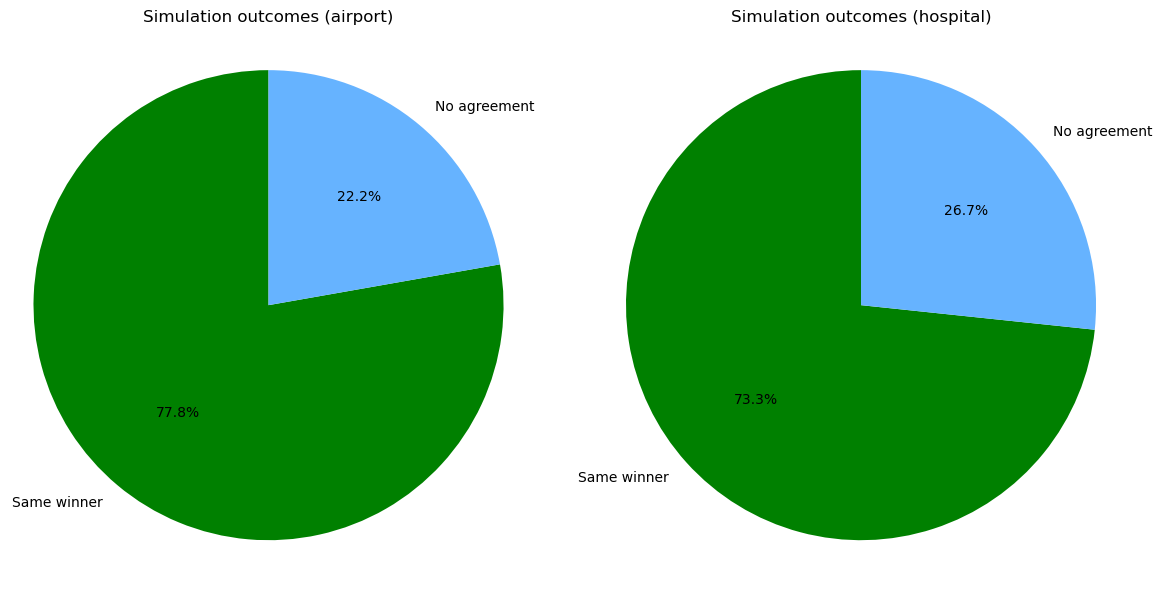

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, ctx in enumerate(['airport', 'hospital']):
    #ctx_df = onrobot_df[onrobot_df['context'] == ctx]
    ctx_df = df[(df['context'] == ctx) & (df['deployment'] == 'offrobot')]
    agreement_count = ctx_df[ctx_df['result'] != 'no-agreement'].shape[0]
    total_count = ctx_df.shape[0]

    sizes = [agreement_count, total_count - agreement_count]

    axes[idx].pie(sizes, labels=['Same winner', 'No agreement'], colors=['green', '#66b3ff'], autopct='%1.1f%%', startangle=90)
    axes[idx].set_title(f'Simulation outcomes ({ctx})')
    axes[idx].axis('equal')

    print(f"No Agreement in context {ctx}: {total_count - agreement_count}")

plt.tight_layout()
plt.show()
    

In [9]:
no_agreement_df = onrobot_df[(onrobot_df['result'] == 'no-agreement') & (onrobot_df['context'] == 'airport')]
winner_loser_df = onrobot_df[(onrobot_df['result'].isin(['winner', 'loser'])) & (onrobot_df['context'] == 'airport')]

complete_stats = onrobot_df[onrobot_df['context'] == 'airport']['negotiation_time'].describe()

no_agreement_stats = no_agreement_df['negotiation_time'].describe()

winner_loser_stats = winner_loser_df['negotiation_time'].describe()

print("Overall stats (Airport):")
print(complete_stats)

print("\nWhen negotiation ends with agreement:")
print(winner_loser_stats)

print("\nWhen no agreement is reached:")
print(no_agreement_stats)


Overall stats (Airport):
count    180.000000
mean       0.681811
std        0.123708
min        0.397000
25%        0.596000
50%        0.669500
75%        0.758000
max        1.069000
Name: negotiation_time, dtype: float64

When negotiation ends with agreement:
count    140.000000
mean       0.682971
std        0.123505
min        0.397000
25%        0.601750
50%        0.682500
75%        0.758750
max        1.019000
Name: negotiation_time, dtype: float64

When no agreement is reached:
count    40.000000
mean      0.677750
std       0.125908
min       0.547000
25%       0.593000
50%       0.634500
75%       0.708000
max       1.069000
Name: negotiation_time, dtype: float64


In [10]:
no_agreement_df = onrobot_df[(onrobot_df['result'] == 'no-agreement') & (onrobot_df['context'] == 'hospital')]
winner_loser_df = onrobot_df[(onrobot_df['result'].isin(['winner', 'loser'])) & (onrobot_df['context'] == 'hospital')]

complete_stats = onrobot_df[onrobot_df['context'] == 'hospital']['negotiation_time'].describe()

no_agreement_stats = no_agreement_df['negotiation_time'].describe()

winner_loser_stats = winner_loser_df['negotiation_time'].describe()

print("Overall stats (Hospital):")
print(complete_stats)

print("\nWhen negotiation ends with agreement:")
print(winner_loser_stats)

print("\nWhen no agreement is reached:")
print(no_agreement_stats)


Overall stats (Hospital):
count    180.000000
mean       0.663767
std        0.104307
min        0.436000
25%        0.596000
50%        0.659000
75%        0.728000
max        1.010000
Name: negotiation_time, dtype: float64

When negotiation ends with agreement:
count    132.000000
mean       0.662576
std        0.114715
min        0.436000
25%        0.591500
50%        0.662500
75%        0.732750
max        1.010000
Name: negotiation_time, dtype: float64

When no agreement is reached:
count    48.000000
mean      0.667042
std       0.068868
min       0.532000
25%       0.620000
50%       0.654500
75%       0.707500
max       0.845000
Name: negotiation_time, dtype: float64


In [11]:
negotiation_threshold = (
    df[(df['negotiation_time'] < 0.8) & (df['deployment'] == 'onrobot')]
    .groupby('context')
    .size() / df[df['deployment'] == 'onrobot'].groupby('context').size() * 100
)

print("Negotiations completed in less than 0.8 s:")
print(negotiation_threshold)

Negotiations completed in less than 0.8 s:
context
airport     83.888889
hospital    91.111111
dtype: float64


In [12]:
avg_rounds = onrobot_df.groupby('context')['rounds'].mean()
print("Average number of rounds by context (onrobot):")
print(avg_rounds)

Average number of rounds by context (onrobot):
context
airport     6.555556
hospital    5.888889
Name: rounds, dtype: float64
